<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Loss Minimization</h1>

## 1. Aims
<div class="alert alert-info">
To perform a least squares fit to the Olympic 100m data.
</div>

## 2. Olympic data 
<div class="alert alert-info">
Download the olympic matlab file from the ASI collaborative space. Use the `loadmat()` function from scipy to load the data, then using 'male100' as key retrieve the data from the first column and the labels from the second with the proper indexing.
</div>

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import mean_squared_error
mat = scipy.io.loadmat('olympics.mat')

In [2]:
x = mat['male100'][:,0]
t = mat['male100'][:,1]

In [3]:
print(x.shape)
print(t.shape)

(27,)
(27,)


<div class="alert alert-success">
We can now plot our data.
</div>

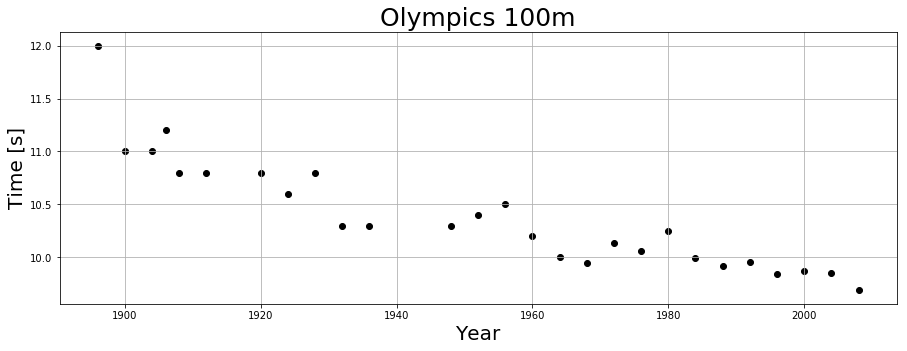

In [4]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='k')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m', fontsize=25)
plt.grid()
plt.show()

<div class="alert alert-info">
We’ll now fit the model $t = w_0 + w_1x$ to our data. This model fitting step is something we
might wish to do more than once, so it makes sense to create a function, `lsfit()`.

Recall from the lectures that

$$
w_1 = \dfrac {\bar {tx} - \bar t \bar x}{\bar {x^2} - \bar {x}^2}
$$

$$
w_0 = \bar t - w_1 \bar x
$$

where 
$$
\bar f(x) = \dfrac {1}{N} \sum_{n=1}^{N} f_n(x)
$$
</div>

In [5]:
def lsfit(x,t):
    """
    Least-Squares fit: 
    given data and labels, it returns W and the loss (MSE)
    """
    x, t = np.array(x), np.array(t)
    x_mu, t_mu = np.mean(x), np.mean(t)
    xt = x*t
    xt_mu = np.mean(xt)
    x2_mu = np.mean(x*x)
    w1 = (xt_mu-x_mu*t_mu)/(x2_mu-x_mu**2)
    w0 = t_mu - w1*x_mu
    N = len(x)
    loss = np.sum((t-w0-w1*x)**2)/N
    return w0, w1, loss

In [6]:
w0, w1, loss = lsfit(x, t)

<div class="alert alert-info">
Inspect the values in the variables `w0` and `w1` – do they agree with the values provided in the notes?
</div>

In [7]:
print("w0", w0)
print("w1", w1)

w0 36.4164559025
w1 -0.013330885711


<div class="alert alert-success">
Yes, same values as in the notes.
</div>

<div class="alert alert-info">
We can now plot the line on top of our data. The plotted line should run through the data as shown in the lectures.
</div>

In [8]:
def get_lin_regr(x, w):
    """Evaluate a polynomial at points x"""
    return np.polynomial.polynomial.polyval(x, w)

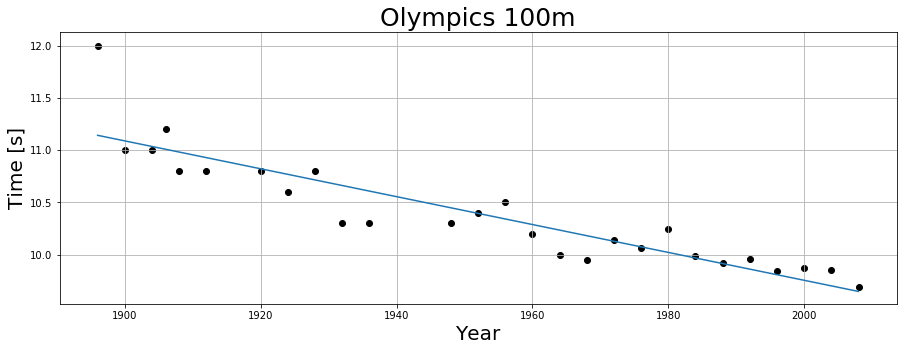

In [9]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='k')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.plot(x, get_lin_regr(x, np.array([w0, w1])))
plt.title('Olympics 100m', fontsize=25)
plt.grid()
plt.show()

<div class="alert alert-info">
Extend your script in the following ways:
<ul>
<li>Add comments so that others (and you) can see what you’ve done.
<li>Put labels on the plot axes – xlabel and ylabel will be useful.
<li>Compute the average loss: $L = \dfrac{1}{N} \sum_{n=1}^{N} (t_n - w_0 - w_1x_n )^2 $. Do this in the lsfit function
and return it as an additional variable.
<li>Fit a function to the women’s 100m instead. This data is inside the same matlab file (use 'female100' as key).
<li>Fit a function to the men’s and women’s 100m and find the year that the two races are
predicted to have the same winning time.
</ul>
</div>

In [10]:
x_fem = mat['female100'][:,0]
t_fem = mat['female100'][:,1]
w0_fem, w1_fem, loss = lsfit(x_fem, t_fem)

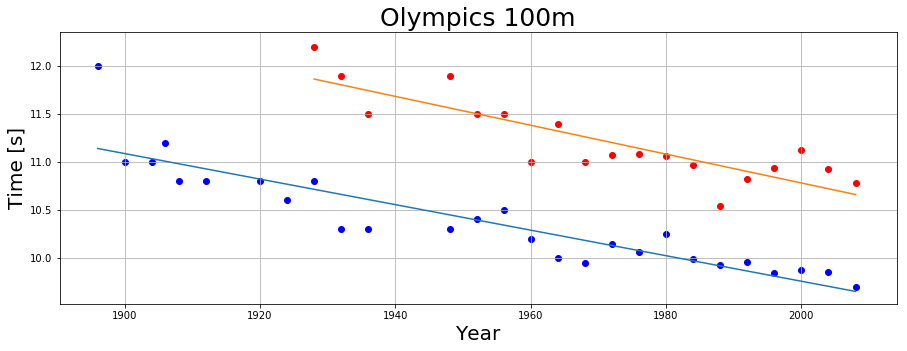

In [11]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='b')
ax.scatter(x_fem, t_fem, color='r')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.plot(x, get_lin_regr(x,np.array([w0,w1])))
plt.plot(x_fem, get_lin_regr(x_fem,np.array([w0_fem,w1_fem])))

plt.title('Olympics 100m', fontsize=25)
plt.grid()
plt.show()

In [12]:
year = int((w0 - w0_fem)/(w1_fem-w1) - ((w0 - w0_fem)/(w1_fem-w1) % 4) + 4)
print("Same winning time in Year: ", year)

Same winning time in Year:  2592


<h1 style="text-align:center">Loss minimization in vector form</h1>

## 1. Aims:
<div class="alert alert-info">
<ul>
<li> To become familiar with vector and matrix operations in python.
<li> Implementing a cross-validation procedure for model selection.
</ul>
</div>

## 2. Vectors and matrices
<div class="alert alert-info">
Load the olympics data, as in the previous lab, for `male100`.
</div>

## 2.1. Least squares in matrix form
<div class="alert alert-info">
In the lectures, we derived the following expression for the least squares solution in vector form:

$$
\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}
$$
where
$$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   1 & x_1^1 & \dots & x_1^K\\
   1 & x_2^1 & \dots & x_2^K\\
   \vdots &    \vdots & &   \vdots \\
   1 & x_N^1 & \dots & x_N^K\\
  \end{array} } \right]
$$
Our first step is to create X. This can be done in many ways. One of them is using a double list comprehension (one index for the row and one for the column), while another one is using the numpy `column_stack()` function. When dealing with matrices, `numpy.matrix` is a good data type to work with. In any case, inspect X to make sure it looks OK. To fit higher order polynomials, we need to add extra columns to X, therefore build it with $K$ as a parameter.
</div>

<div class="alert alert-info">
Given X, we can easily compute $\hat{\mathbf{w}}$ using `*`, `.I` and `.T` operators to respectively multiply, invert and transpose matrices. Make sure to correctly multiply vectors, i.e., $\mathbf{t}$, and matrices.
</div>

<div class="alert alert-info">
Write a function that computes $\hat{\mathbf{w}}$ for a given $\mathbf{X}$, $\mathbf{t}$ and $K$.
It could be useful to also define a function to create $X$ given an $x$ and a $K$.
</div>

In [13]:
def get_X(x, n):
    # check if we have high values
    if np.min(x) > 1000:
        # rescaling for high orders
        if n > 3:
            x_ = x - np.min(x)
            x_ /= 4 
        else:
            x_ = x
    else:
        x_ = x
    X_ = np.matrix([[x_i**k for k in range(n+1)] for x_i in x_])
    return X_

In [14]:
def get_w_hat(x_, y, n):
    X = get_X(x_, n)
    t = np.matrix(y).T
    return (X.T*X).I*X.T*t

<div class="alert alert-success">
Let's try now different values of K.
</div>

In [15]:
def lsfit_vect(x, t, k):
    X = get_X(x, k)
    w_hat = get_w_hat(x, t, k)
    t = np.matrix(t).T
    loss = ((t-X*w_hat).T)*(t-X*w_hat)/np.size(t) 
    return w_hat, loss.tolist()[0][0]

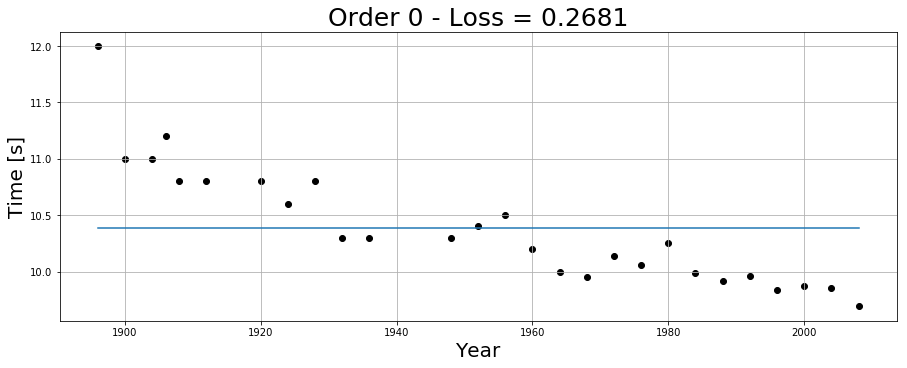

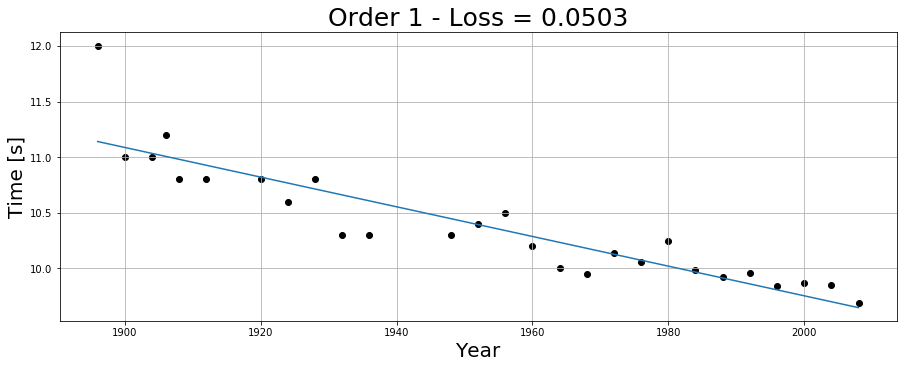

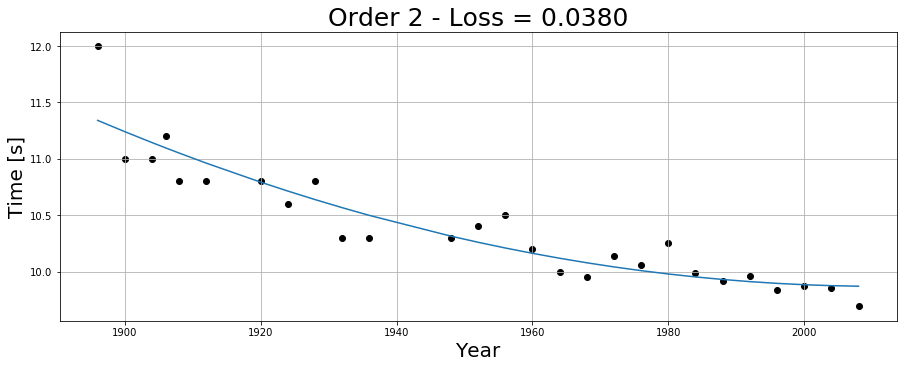

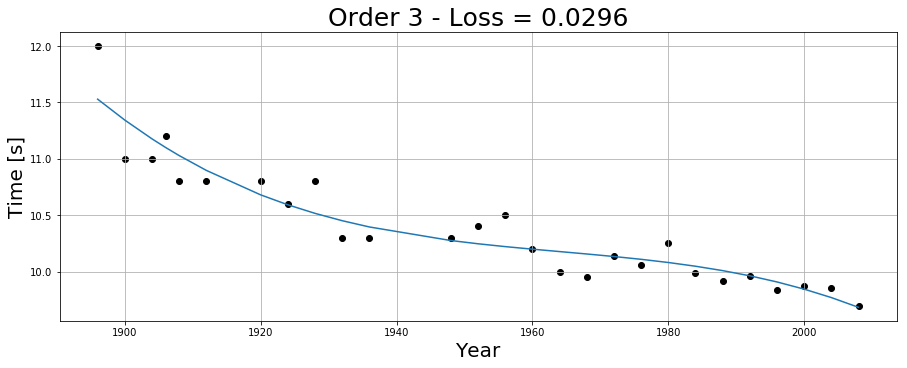

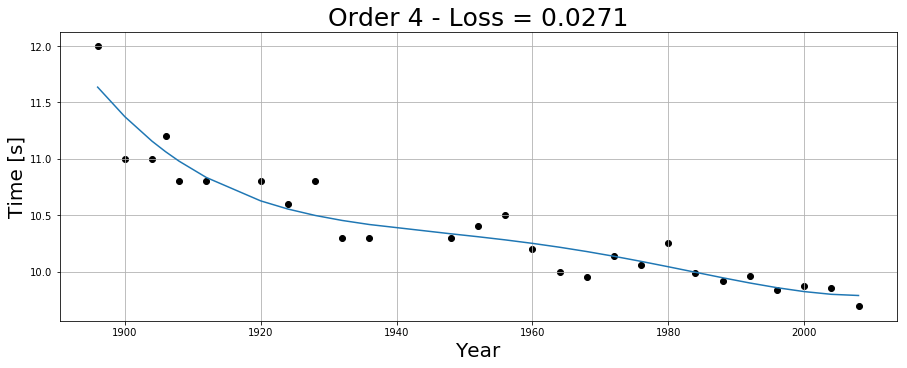

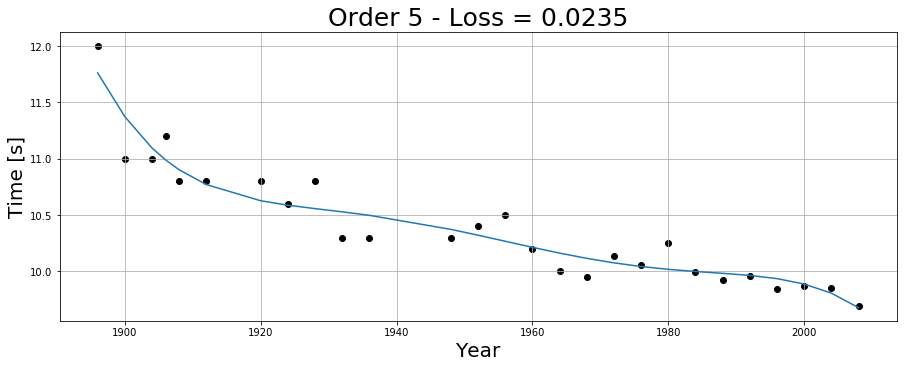

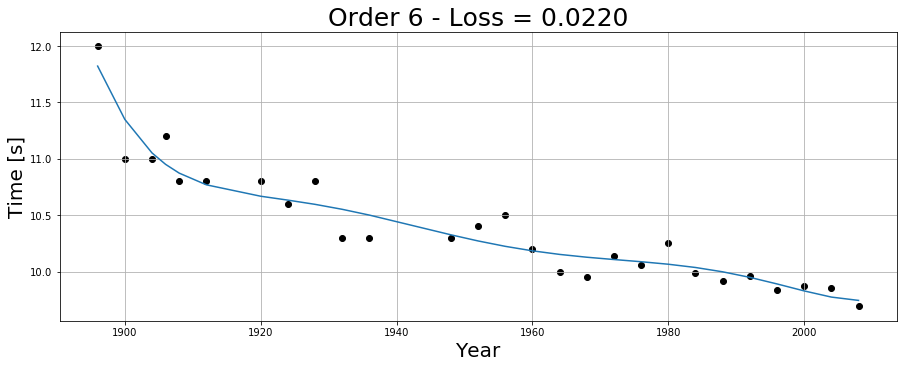

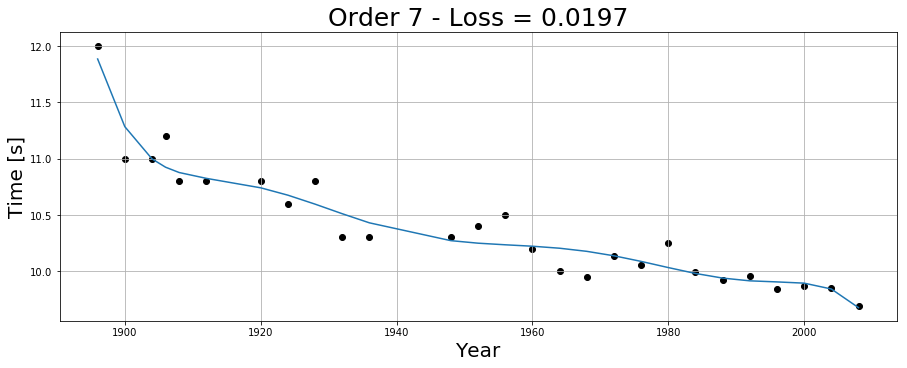

In [16]:
K = 8
loc = K*100 +11
for k in range(K):
    plt.figure(figsize=(15,50))
    w_hat, loss = lsfit_vect(x, t, k)
    X = get_X(x, k)
    Y = np.matrix((X*w_hat).T)
    plt.subplot(loc+k)
    ax = plt.gca()
    ax.scatter(x, t, color='k')
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Time [s]', fontsize=20)
    plt.plot(x, Y.tolist()[0])
    plt.title('Order %d - Loss = %.4f' %(k, loss),  fontsize=25)
    plt.grid()
plt.show()

<div class="alert alert-success">
Increasing the order implies a decreasing loss as expected.
</div>

<div class="alert alert-info">
To make predictions, at a column vector of test points, `x_test`, we need to create `X_test` and then multply it by `w_hat`. For example:</div>

In [17]:
k_pred = 3
x_test = [2012, 2016]
X_test = get_X(x_test, k_pred)
w_hat = get_w_hat(x, t, k_pred)
predictions = X_test*w_hat
print("Predicted time in 2012:",predictions[0])
print("Predicted time in 2016:",predictions[1])

Predicted time in 2012: [[ 9.58291972]]
Predicted time in 2016: [[ 9.46895102]]


<div class="alert alert-info">
Write a function that, when given `x`, `t` and `x_test`, computes `w_hat` and makes predictions at `x_test`.</div>

In [18]:
def predict(x, t, x_test, K=1):
    w_hat = get_w_hat(x, t, K)
    X_test = get_X(x_test, K)
    return X_test*w_hat

In [19]:
print(predict(x, t, x_test, 1))

[[ 9.59471385]
 [ 9.54139031]]


<div class="alert alert-info">You may find it interesting to test your code with different datasets. The following code will generate data from a third order polynomial:</div>

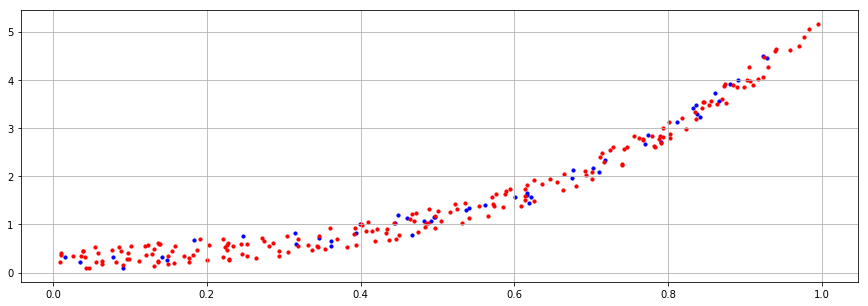

In [20]:
x_ex = np.sort(np.random.rand(50))
x_test_ex = np.sort(np.random.rand(200))
noise = 0.5
t_ex = 5*(x_ex**3) - x_ex**2 + x_ex + np.random.rand(50)*noise # third order plus noise
t_test_ex = 5*(x_test_ex**3) - x_test_ex**2 + x_test_ex + np.random.rand(200)*noise;
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x_ex, t_ex, color='b', s=10)
ax.scatter(x_test_ex, t_test_ex, color='r', s=10)
plt.grid()
plt.show()

In [21]:
K_ex = 7
mean_err_ex = []
for k in range(1,K_ex):
    predictions_ex = np.array(predict(x_ex, t_ex, x_test_ex, k)).reshape(-1)
    mean_err_ex.append(mean_squared_error(t_test_ex, predictions_ex))

In [22]:
mean_err_ex

[0.24485326569927701,
 0.027172055064651337,
 0.028123499048000929,
 0.029539745140144711,
 0.027695516195730168,
 0.033075567709839965]

<div class="alert alert-success">
The smallest error is obtained with order 3 as expected. The small value obtained by order 2 can be explained by looking at the plot above where we see a quadratic trend even if the polinomial har order 3. 
</div>

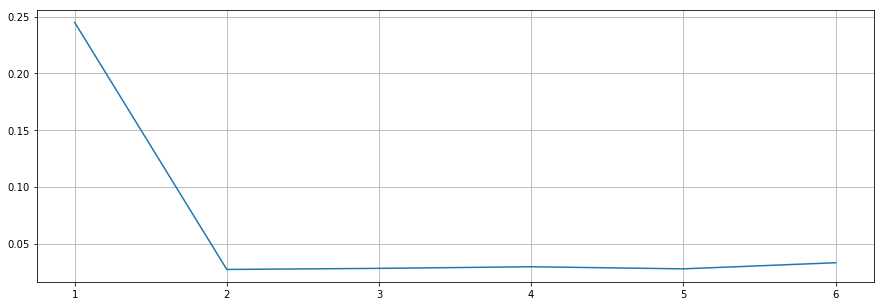

In [23]:
plt.figure(figsize=(15,5))
x_ax = range(1,K_ex)
plt.plot(x_ax,mean_err_ex)
plt.grid()
plt.show()

<div class="alert alert-info">
Try different values of K and comment the results.
<br><br>
If you want to look at the effect of increasing the polynomial order above 4, you’ll need to
rescale the $x$ (Olympic year) values (do this before you calculate all the $x^k$ stuff)(remember that you need to do the same thing to any test years too...).
</div>

<div class="alert alert-success">
I added the normalization step in `get_X()`.
</div>

## 3. Cross-validation

### Write a script that will perform LOO cross-validation
<div class="alert alert-info">
Some hints (you can generate data using the code above – you won’t need to define `x_test` or `t_test`)
<br>
You’ll need to:
<ul>
<li> Write a loop that removes the data-points one by one, find w_hat on the
reduced dataset and then compare the prediction on the removed data-point and compare
it to the true value.

<li> Create a copy of `X` with the n-th data-point (row) removed

<li> Create a copy of the n-th row of `X`

</ul>
You can use your previous function for finding `w` hat and pass it `trainX` instead of `X`.
<br>
Plot the average error for different polynomial orders. 
<br><br>
Does your code predict the correct one?
</div>

<div class="alert alert-success">
Let's generate the dataset from scratch.
</div>

In [24]:
x_ex = np.sort(np.random.rand(50))
noise = 0.5
t_ex = 5*(x_ex**3) - x_ex**2 + x_ex + np.random.rand(50)*noise # third order plus noise

In [25]:
def LOOCV(data, labels, order):
    mse = np.zeros((order, len(data)))
    for k in range(order):
        for n in range(len(data)):
            x_train = np.array([el for i,el in enumerate(data) if i != n])
            t_train = np.array([el for i,el in enumerate(labels) if i != n])
            x_test = np.array(data[n]).reshape(-1)
            t_test = np.array(labels[n]).reshape(-1)
            t_pred = np.array(predict(x_train, t_train, x_test, k)).reshape(-1)
            mse[k,n] = mean_squared_error(t_test, t_pred)
    mse_order = np.mean(mse, axis=1)
    return mse_order

In [26]:
mse_LOOCV = LOOCV(x_ex, t_ex, 8)
for i in range(mse_LOOCV.size):
    print("Order:", i, "MSE:", mse_LOOCV[i])

Order: 0 MSE: 1.60466783286
Order: 1 MSE: 0.252370771045
Order: 2 MSE: 0.035462324137
Order: 3 MSE: 0.026028035998
Order: 4 MSE: 0.0266136843965
Order: 5 MSE: 0.0264737906892
Order: 6 MSE: 0.0267999761705
Order: 7 MSE: 0.0291810729358


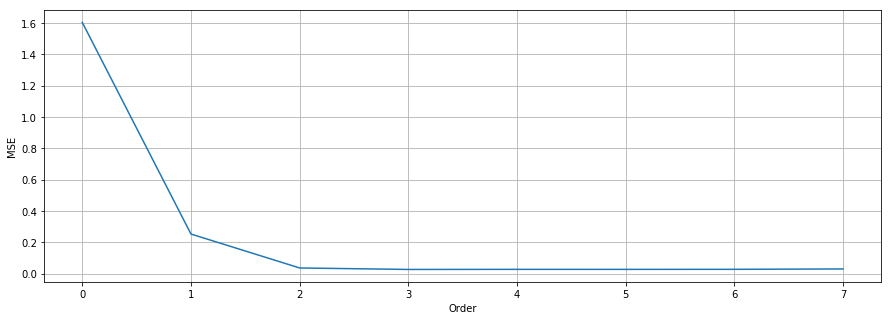

In [27]:
plt.figure(figsize=(15,5))
plt.plot(mse_LOOCV)
plt.xlabel("Order")
plt.ylabel("MSE")
plt.grid()
plt.show()

<div class="alert alert-success">
With LOOCV we see that the order 3 is the best one on the test set as it should be.
</div>

<h1 style="text-align:center">Bayesian Linear Regression</h1>


## 1. Aims
<div class="alert alert-info">
<ul>
<li>Implement the maximum likelihood estimate.
<li>Use this to explore uncertainty in parameter values.
<li>Make predictions.
</ul>
</div>

## 2. LOO CV
<div class="alert alert-info">
Make sure you’ve completed the previous assignments.
</div>

## 3. Maximum likelihood
<div class="alert alert-info">
1. Using the ML estimators given in the lectures, compute $\hat{\mathbf{w}}$ and $\hat{\sigma^2}$ on the Olympic data for polynomials of first, second and third order. 
<br>
2. Plot polynomial order versus $\hat{\sigma^2}$. What do you expect to see? What do you see?
</div>


In [28]:
def get_sigma2_hat(X, w_hat, t):
    t_ = np.matrix(t).T
    tXw = t_ - X*w_hat
    return np.float((tXw.T)*tXw/len(t));

In [29]:
K = 4
sigma2_hat_values = []
for k in range(1,K):
    X = get_X(x, k)
    w_hat = get_w_hat(x, t, k)
    sigma2_hat = get_sigma2_hat(X, w_hat, t)
    sigma2_hat_values.append(sigma2_hat)

In [30]:
sigma2_hat_values

[0.050307110475657925, 0.03795854663471811, 0.029611322752659205]

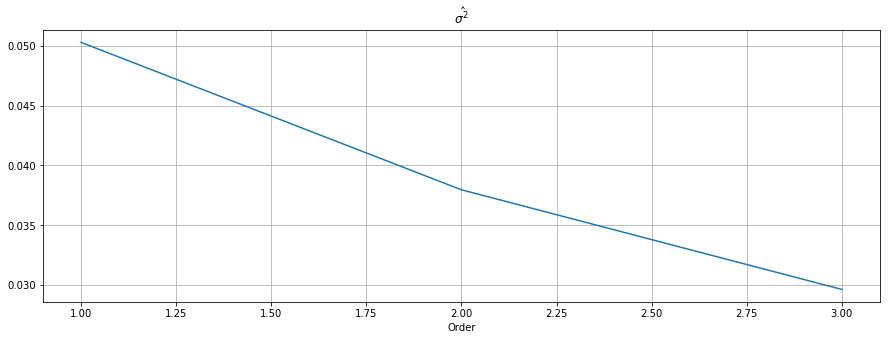

In [31]:
plt.figure(figsize=(15,5))
x_ax = range(1,K)
plt.plot(x_ax,sigma2_hat_values)
plt.xlabel("Order")
plt.title(r'$\hat{\sigma^2}$')
plt.grid()
plt.show()

<div class="alert alert-success">
We expected to see $\hat{\sigma^2}$ decreasing when the order increases and the plot above confirm this.
</div>

<div class="alert alert-info">
3. Using your CV code from the previous exercise, perform a LOO CV analysis for maximum likelihood for polynomials of order 0 to 8.</div>

In [32]:
mse_LOOCV_olympic = LOOCV(x, t, 9)
for i in range(mse_LOOCV_olympic.size):
    print("Order:", i, "MSE:", mse_LOOCV_olympic[i])

Order: 0 MSE: 0.289111538462
Order: 1 MSE: 0.0624318496729
Order: 2 MSE: 0.0565943627669
Order: 3 MSE: 0.052905292175
Order: 4 MSE: 1.86431243896
Order: 5 MSE: 2.19621238649
Order: 6 MSE: 2.3689265419
Order: 7 MSE: 2.55000734456
Order: 8 MSE: 2.72846785095


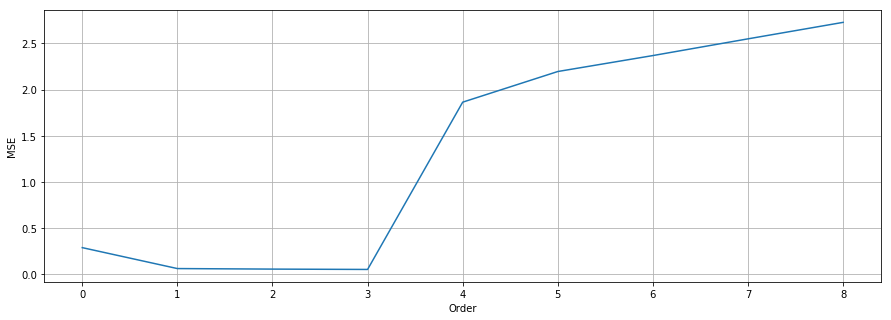

In [33]:
plt.figure(figsize=(15,5))
plt.plot(mse_LOOCV_olympic)
plt.xlabel("Order")
plt.ylabel("MSE")
plt.grid()
plt.show()

<div class="alert alert-success">
The best results are obtained with order 3, 2 and 1. Above these values we get overfitting.
</div>

## 4. Uncertainty in estimates
<div class="alert alert-info">
1. For the first order polynomial, compute $cov(\hat{\mathbf{w}})$ (use $\hat{\sigma^2}$ in place of $\sigma^2$).
<br><br>
$$
cov(\hat{\mathbf{w}}) = \sigma^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$
</div>


In [34]:
def get_cov_w(x, t, order):
    X = get_X(x, order)
    w_hat = get_w_hat(x, t, order)
    sigma2_hat = get_sigma2_hat(X, w_hat, t)
    cov_w_hat = sigma2_hat * ((X.T)*X).I
    return cov_w_hat 

In [35]:
order = 1
X = get_X(x, order)
w_hat = get_w_hat(x, t, order)
cov_w_hat = get_cov_w(x, t, order)
cov_w_hat

matrix([[  5.79720941e+00,  -2.96836413e-03],
        [ -2.96836413e-03,   1.52038987e-06]])

<div class="alert alert-info">
2. Sample 10 values of $\hat{\mathbf{w}}$ from $\mathcal{N}(\hat{\mathbf{w}}, cov(\hat{\mathbf{w}}))$ using `multivariate_normal()` from the numpy random module and plot all the models with the data.
</div>


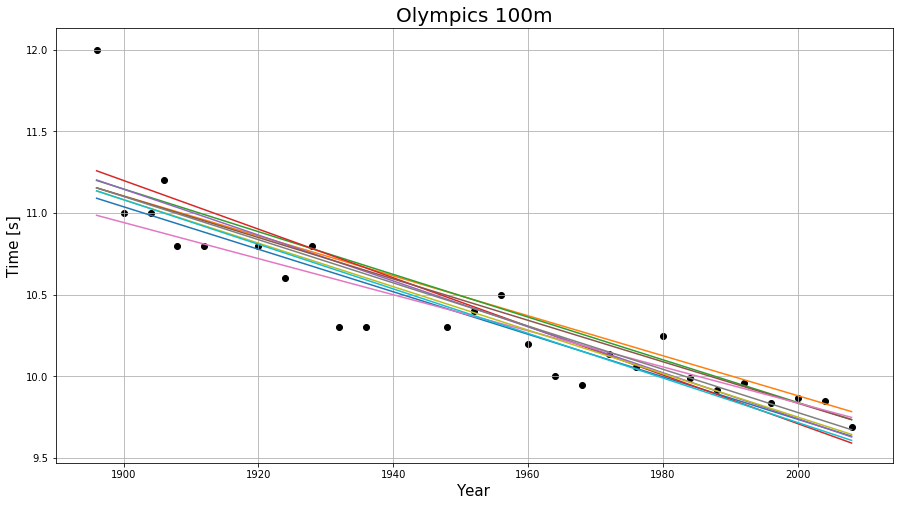

In [36]:
w_samples = []
t_pred = []
plt.figure(figsize=(15,8))
plt.subplot(111)

for i in range(10):
    w_samples.append(np.matrix(np.random.multivariate_normal(np.array(w_hat).T[0], cov_w_hat)).T )
    t_pred.append(X*w_samples[i])
    plt.plot(x, t_pred[i])
    
plt.scatter(x, t, color='k')    
plt.xlabel('Year', fontsize=15)
plt.ylabel('Time [s]', fontsize=15)
plt.title('Olympics 100m', fontsize=20)
plt.grid()
plt.show()

## 5. Uncertainty in predictions
<div class="alert alert-info">
1. Load synthetic_data.mat from the ASI collaborative space. It includes the
variables:
<ul>
<li>x
<li>t
<li>testx
</ul>
2. Pick a polynomial order between 1 and 7 (repeat with others if you have time).
<br>
3. Find $cov(\hat{\mathbf{w}})$ and $\hat{\sigma^2}$.
</div>


In [37]:
synth = scipy.io.loadmat('synthetic_data.mat')
x = synth['x'].reshape(-1)
t = synth['t'].reshape(-1)
x_test = synth['testx'].reshape(-1)
print(x.shape)
print(t.shape)
print(x_test.shape)

(50,)
(50,)
(47,)


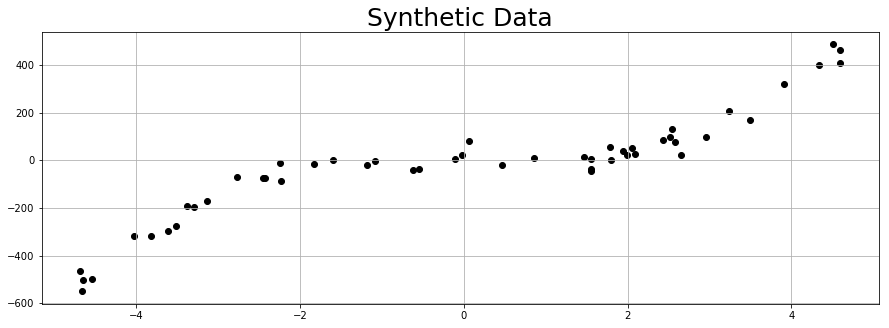

In [38]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='k')
plt.title('Synthetic Data', fontsize=25)
plt.grid()
plt.show()

In [39]:
order = 3
X = get_X(x, order)
w_hat = get_w_hat(x, t, order)
sigma2_hat = get_sigma2_hat(X, w_hat, t)

<div class="alert alert-info">
4. Compute the predictive means. If you create $\mathbf{X}_{new}$ in exactly the same way as you created X, you’ll be able to do this for all test points in one operation:
$$
t_{new} = \mathbf{X}_{new} \mathbf{\hat{\mathbf{w}}}
$$
</div>


In [40]:
X_test = get_X(x_test, order)
t_test = X_test*w_hat

<div class="alert alert-info">
5. For each $\mathbf{x_{new}}$ (each value of `testx` expanded into a vector, i.e., each row of $\mathbf{X}_{new}$), compute the predictive variance:
$$
\sigma^2_{new} = \sigma^2 \mathbf{x^T_{new}}(\mathbf{X^TX})^{-1} \mathbf{x_{new}}
$$
</div>

In [41]:
sigma2_new = np.zeros(x_test.size)
for i in range(x_test.size):
    tmp = X_test[i,:].T
    xtxi = ((X.T)*X).I
    sigma2_new[i] = sigma2_hat*tmp.T*xtxi*tmp

<div class="alert alert-info">
6. Use `errorbar()` to plot the data.
</div>

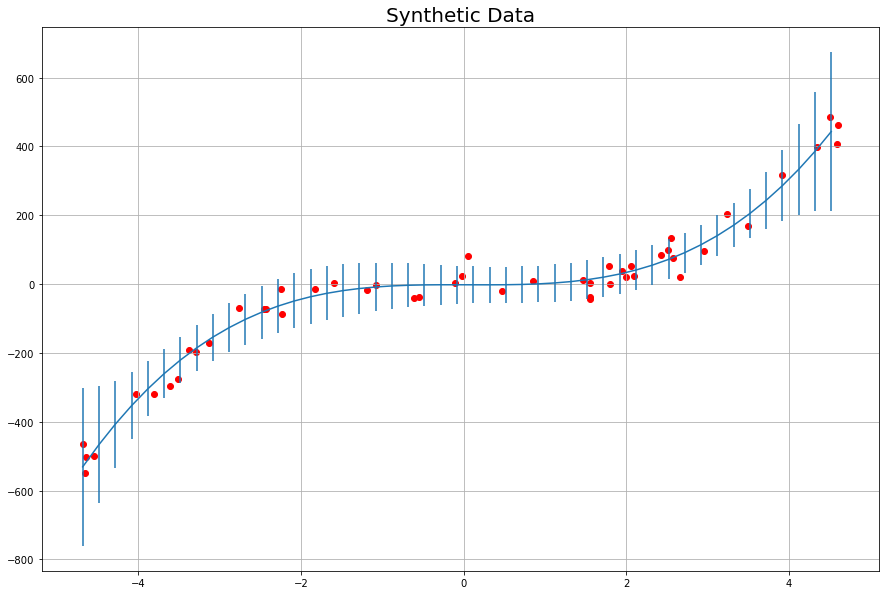

In [42]:
plt.figure(figsize=(15,10))
plt.errorbar(x_test, t_test, yerr=sigma2_new)
plt.scatter(x, t, color='r')
plt.title('Synthetic Data', fontsize=20)
plt.grid()
plt.show()

<div class="alert alert-info">
7. What do you notice – is it what you expect?
</div>

<div class="alert alert-success">
We have less uncertainty where we have more data and more uncertinty at the borders.
</div>

<div class="alert alert-info">
8. Repeat with the data given in the file synthetic_data_2.mat. What do you notice?
</div>

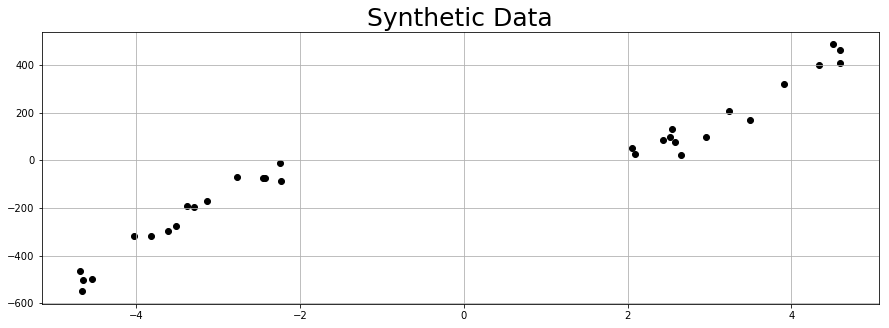

In [43]:
synth = scipy.io.loadmat('synthetic_data_2.mat')
x = synth['x'].reshape(-1)
t = synth['t'].reshape(-1)
x_test = synth['testx'].reshape(-1)
# print(x.shape)
# print(t.shape)
# print(x_test.shape)
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='k')
plt.title('Synthetic Data', fontsize=25)
plt.grid()
plt.show()

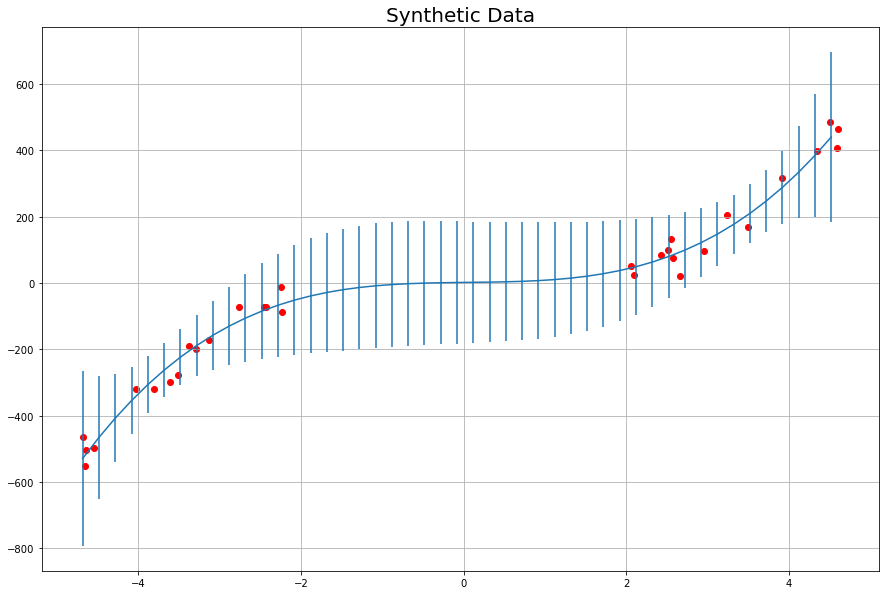

In [44]:
order = 3
X = get_X(x, order)
w_hat = get_w_hat(x, t, order)
sigma2_hat = get_sigma2_hat(X, w_hat, t)
X_test = get_X(x_test, order)
t_test = X_test*w_hat
sigma2_new = np.zeros(x_test.size)
for i in range(x_test.size):
    tmp = X_test[i,:].T
    xtxi = ((X.T)*X).I
    sigma2_new[i] = sigma2_hat*tmp.T*xtxi*tmp
plt.figure(figsize=(15,10))
plt.errorbar(x_test, t_test, yerr=sigma2_new)
plt.scatter(x, t, color='r')
plt.title('Synthetic Data', fontsize=20)
plt.grid()
plt.show()

<div class="alert alert-success">
Uncertainty is much higher in regions where we don't have data.
</div>

<h1 style="text-align:center">Bayesian inference for a coin tossing experiment</h1>


## 1. Aims:
<div class="alert alert-info">
<ul>
<li> To become familiar with statistical operations in python.
<li> To do some simple Bayesian things.
</ul>
</div>

## 2. Coin Tossing
### 2.1 Computing posterior
<div class="alert alert-info">
The beta probability density function is defined as:
$$
p(r \vert \alpha, \beta) = \dfrac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}r^{\alpha-1}(1-r)^{\beta-1} 
$$
where $0 \le r \le 1$ and $\alpha, \beta> 0$.
You can use the `plot_beta()` function.
</div>

In [62]:
from scipy.stats import beta
from scipy.special import gamma as gamma_func
from scipy.misc import comb

In [46]:
def plot_beta(a,b, plot=False):
    plt.figure(figsize=(15,5))
    x = np.linspace(0, 1, 1000)
    plt.plot(x, beta.pdf(x, a, b),'r')
    plt.title("beta pdf: alpha=" + str(a) + " beta=" + str(b))
    plt.show()

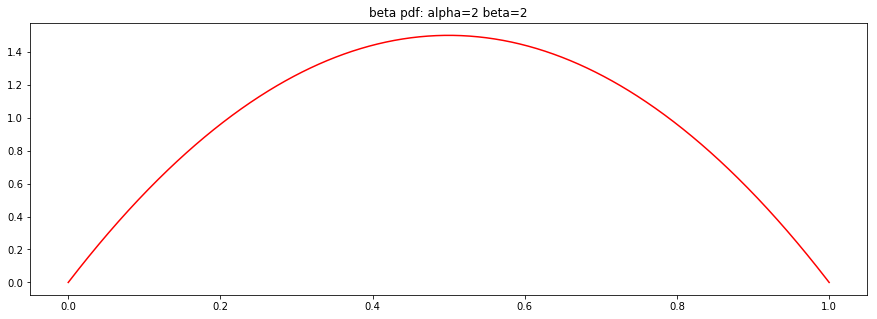

In [47]:
plot_beta(a=2, b=2)

<div class="alert alert-info">
1. $r$ is the probability of some hypothetical coin landing heads. The beta distribution is a suitable prior distribution for $r$. Choose 2 different pairs of values $\alpha$ and $\beta$ and plot the corresponding densities. For both cases, describe the possible beliefs they encode about the coin. Note, there is no ‘right’ answer here, just think about how likely different values of $r$ are in your densities and how this reflects on the coin.
</div>

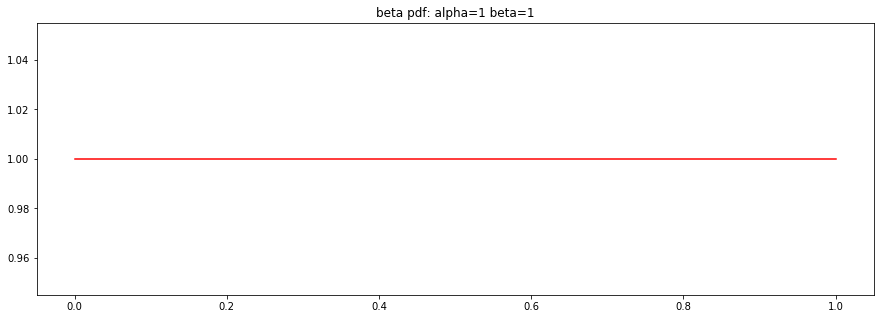

In [48]:
plot_beta(a=1, b=1)

<div class="alert alert-success">
Here, we assume we know nothing about coin tossing.
</div>

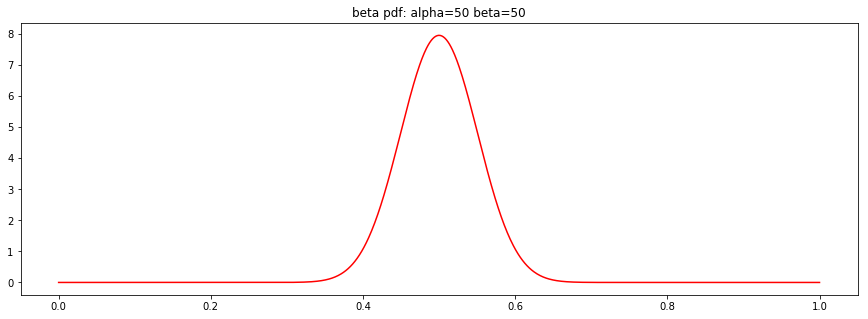

In [49]:
plot_beta(a=50, b=50)

<div class="alert alert-success">
Here, we assume we have a fair coin.
</div>

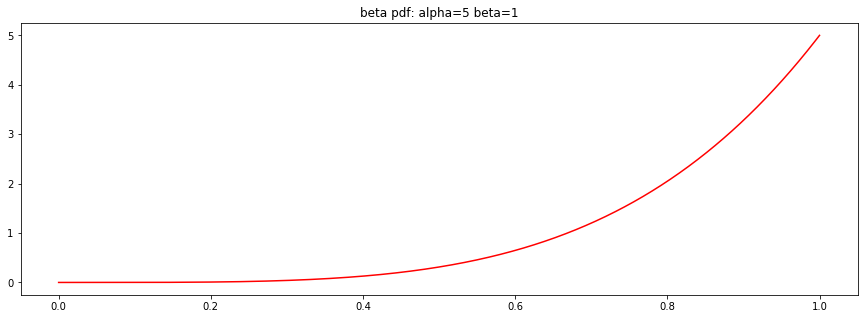

In [50]:
plot_beta(a=5, b=1)

<div class="alert alert-success">
Here, we assume that the coin is biased to generate more heads than tails (5 coins out of 6 will come up heads)
</div>

<div class="alert alert-info">
2. `coin1()` and `coin2()` are two ‘coins’ that you can use. In either case, calling the function with an argument N tosses the coin N times and returns the number of heads. Pick either one and using the equations we derived in the class, along with any choice for $\alpha$ and $\beta$, plot the posterior density for $r$ after $N = 1, 5, 10, 100$ tosses. Use `plot_beta()` to do the plotting. You can put them all on one plot or all on separate plots. Explain what you see.
</div>

In [51]:
def coin1(N):
    return sum(np.random.random(N)<=0.3)
def coin2(N):
    return sum(np.random.random(N)<=0.8)

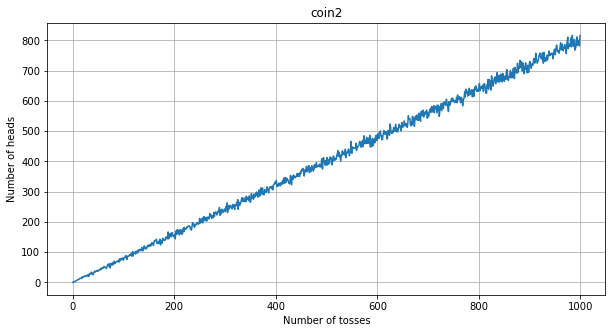

In [52]:
yN = [coin2(N) for N in range(1000)]
plt.figure(figsize=(10,5))
plt.plot(list(range(1000)), yN)
plt.xlabel("Number of tosses")
plt.ylabel("Number of heads")
plt.title("coin2")
plt.grid()
plt.show()

<div class="alert alert-success">
So, `coin2()` is biased to generate more heads (roughly 8 out of 10).
</div>

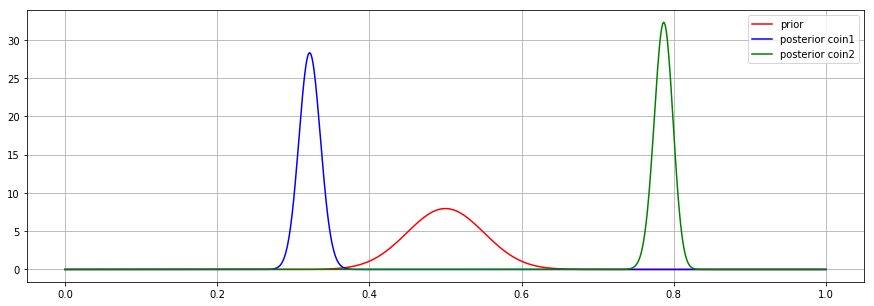

In [53]:
N = 1000
alpha1 = 50
beta1 = 50
yN1, yN2 = coin1(N), coin2(N)
gamma1, gamma2 = yN1 + alpha1, yN2 + alpha1
delta1, delta2 = beta1 + N - yN1, beta1 + N - yN2
plt.figure(figsize=(15,5))
x = np.linspace(0, 1, 1000)
plt.plot(x, beta.pdf(x, alpha1, beta1),'r', label='prior')
plt.plot(x, beta.pdf(x, gamma1, delta1),'b', label='posterior coin1')
plt.plot(x, beta.pdf(x, gamma2, delta2),'g', label='posterior coin2')
plt.legend()
plt.grid()
# plt.title("beta pdf: alpha=" + str(a) + " beta=" + str(b))
plt.show()

<div class="alert alert-success">
We assumed a fair coin and both coins turned out to be biased. We see that coin2 is not centered in 0.8 due to our prior assumption.
</div>

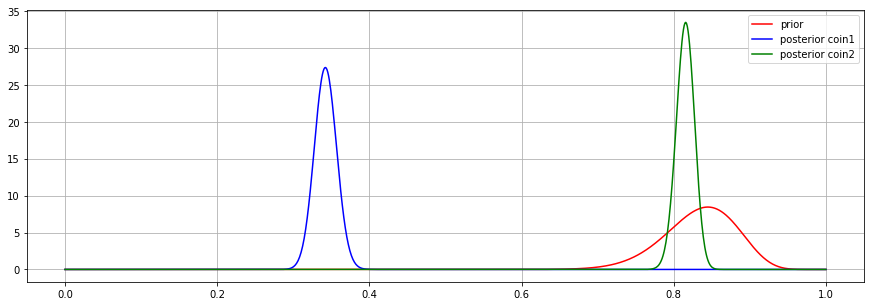

In [55]:
N = 1000
alpha1 = 50
beta1 = 10
yN1, yN2 = coin1(N), coin2(N)
gamma1, gamma2 = yN1 + alpha1, yN2 + alpha1
delta1, delta2 = beta1 + N - yN1, beta1 + N - yN2
plt.figure(figsize=(15,5))
x = np.linspace(0, 1, 1000)
plt.plot(x, beta.pdf(x, alpha1, beta1),'r', label='prior')
plt.plot(x, beta.pdf(x, gamma1, delta1),'b', label='posterior coin1')
plt.plot(x, beta.pdf(x, gamma2, delta2),'g', label='posterior coin2')
plt.legend()
plt.grid()
plt.show()

<div class="alert alert-success">
Here instead, we assumed a biased coin and coin2 is now centered above 0.8.
Let's focus now on coin2 and let's change N.
</div>

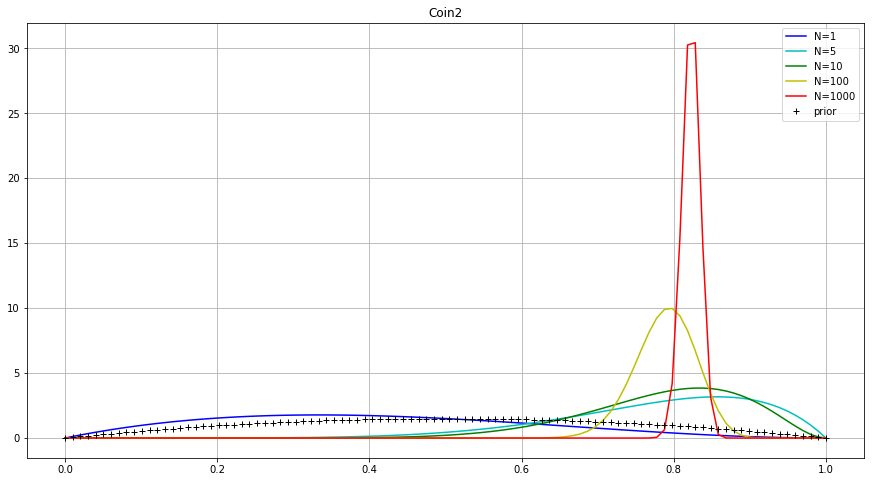

In [56]:
N = [1, 5, 10, 100, 1000]
cs = ['b', 'c', 'g', 'y', 'r']
a = 2
b = 2
x = np.linspace(0, 1, 100)
plt.figure(figsize=(15,8))
for i,n in enumerate(N):
    yN1= coin2(n)
    gamma = yN1 + a
    delta = b + n - yN1
    plt.plot(x, beta.pdf(x, gamma, delta),color=cs[i], label="N="+str(n))
plt.plot(x, beta.pdf(x, a, b),'k+', label='prior')
plt.title("Coin2")
plt.legend()
plt.grid()
plt.show()

<div class="alert alert-success">
In black the prior, which assumes the coin as unbiased. With only one draw, the probability does not change much and we may think that the coin is still unbiased. As we increase N, the posterior moves towards the real probability and we understand that the coin is biased.
</div>

<div class="alert alert-info">
3. Repeat the previous exercise with a different set of prior parameter values ($\alpha$ and $\beta$). What
do you notice?
</div>

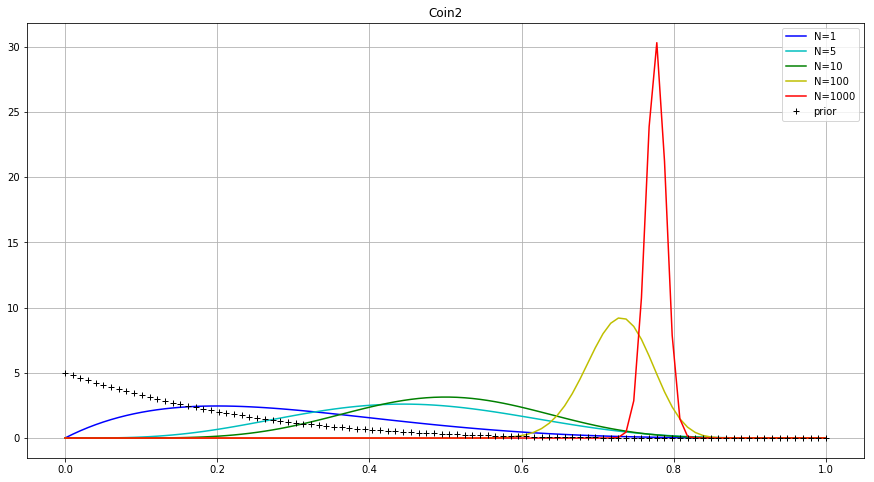

In [57]:
N = [1, 5, 10, 100, 1000]
cs = ['b', 'c', 'g', 'y', 'r']
a = 1
b = 5
x = np.linspace(0, 1, 100)
plt.figure(figsize=(15,8))
for i,n in enumerate(N):
    yN1= coin2(n)
    gamma = yN1 + a
    delta = b + n - yN1
    plt.plot(x, beta.pdf(x, gamma, delta),color=cs[i], label="N="+str(n))
plt.plot(x, beta.pdf(x, a, b),'k+', label='prior')
plt.title("Coin2")
plt.legend()
plt.grid()
plt.show()

<div class="alert alert-success">
We are very suspicious from the beginning about the coin and we assume it is biased to give more tails than heads. After 10 tosses, we understand that we're wrong, the coin is biased to give more heads. 
</div>

### 2.2 Making predictions
<div class="alert alert-info">
`fairground()` is a coin game – you pay £1 to play. The stall owner tosses a coin ten times. If there are 6 or fewer heads, you win £2. The function returns 1 if you win and 0 if you lose.
<br><br>
4. The probability that you win could be approximated by playing the game lots of times and computing the proportion of times you do win! By embedding fairground.m in a loop, approximate the probability that you will win in this way.
</div>

In [58]:
def fairground():
    return sum(np.random.random(10)<0.8) <= 6 # coin2

In [59]:
print("Approx Winning Probability:", sum([fairground() for i in range(10000)])/10000)

Approx Winning Probability: 0.1232


<div class="alert alert-info">
5. In the lectures, we derived an expression for the probability of getting $y_{new}$ heads in N tosses having observed $y_N$ heads in N tosses by taking an expectation with respect to the posterior. Choose $\alpha$ and $\beta$ as you please (as long as you can justify your choice – do you know anything about this coin?). Use `coin2()` to generate $y_N$ for $N = 10$. Compute the posterior parameters. By using them, the expression from the lectures and the following identity, compute the probability that you will win given the coin tosses you have observed (i.e., you just need to add together a series of the expressions you derived in the lecture). Note that this quantity depends on the prior and the particular $y_N$ you get from `coin2()` and therefore could be quite different from the quantity computed in the previous question.
$$
P(y_{new}\le 6 \vert y_N, \alpha, \beta) = \sum_{a=0}^{6} P(y_{new}=a \vert y_N, \alpha, \beta)
$$
</div>

In [63]:
Nlook = 50; # the higher this number, the lower the more accurate our winning probability
yN = coin2(Nlook)
# we assume the coin is unbiased
alpha1 = 2
beta1 = 2
gamma1 = yN + alpha1
delta1 = beta1 + Nlook - yN

N = 10
p_ynew_se_six = 0 # smaller or equal to 6

for ynew in range(7):
    b = comb(N, ynew)
    num = gamma_func(gamma1+delta1)*gamma_func(gamma1+ynew)*gamma_func(delta1+N-ynew)
    den = gamma_func(gamma1)*gamma_func(delta1)*gamma_func(gamma1 + delta1 + N)
    p_ynew_se_six = p_ynew_se_six + ((b*num)/den)

p_ynew_se_six

0.17984619502811122

In [64]:
Nlook = 50; # the higher this number, the lower the more accurate our winning probability
yN = coin2(Nlook)
# we assume the coin is biased
alpha1 = 1
beta1 = 10
gamma1 = yN + alpha1;
delta1 = beta1 + Nlook - yN;

N = 10;
p_ynew_se_six = 0; # smaller or equal to 6

for ynew in range(7):
    b = comb(N, ynew);
    num = gamma_func(gamma1+delta1)*gamma_func(gamma1+ynew)*gamma_func(delta1+N-ynew);
    den = gamma_func(gamma1)*gamma_func(delta1)*gamma_func(gamma1 + delta1 + N);
    p_ynew_se_six = p_ynew_se_six + ((b*num)/den);

p_ynew_se_six

0.38494916096003723

<div class="alert alert-success">
With a different prior (b>>a), we get a higher winning probability.
</div>